In [ ]:
from VR_Trajectory_analysis import *

In [ ]:
directory = '/Users/apaula/ownCloud/MatrexVR1/20250403_ColorGeometry_Data/RunData'

In [ ]:
df = get_combined_df(directory, trim_seconds=1.0)

In [ ]:
df["FlyID"].nunique()

In [ ]:
df = add_trial_id_and_displacement(df)
df = add_trial_time(df)

In [ ]:
df_stationary, df_normal, df_excessive, stationary_ids, normal_ids, excessive_ids = classify_trials_by_displacement(df[df['Scene']=='Choice_noBG'], min_disp=0, max_disp=500)

In [ ]:
plot_trajectories(df_normal, 'normal')

In [ ]:
import pandas as pd
import numpy as np
import re

def parse_angle_from_config(config_filename: str, default_angle: float = 20.0) -> float:
    """
    Extracts the 'XX' in e.g. "constantSize_XXdeg" from the config filename.
    If no match is found (deg info is missing), returns default_angle (usually 20°).
    """
    pattern = r"_([0-9]+)deg_"  # looks for something like "_30deg_"
    match = re.search(pattern, config_filename)
    if match:
        return float(match.group(1))
    else:
        return default_angle

def get_left_right_goals(angle_deg: float, radius: float = 60.0):
    """
    Given a total separation angle (in degrees) and a circle radius, 
    return (x,z) for the left goal and right goal, respectively,
    placed symmetrically about the positive z-axis.
    """
    # Convert half the separation angle to radians
    half_angle_rad = np.radians(angle_deg / 2.0)

    # By convention here:
    #  - "left" is at -half_angle_rad
    #  - "right" is at +half_angle_rad
    #
    # Since 0° is along +z, we do:
    #   x = r * sin(theta)
    #   z = r * cos(theta)
    #
    # left uses -half_angle_rad; right uses +half_angle_rad
    left_x = radius * np.sin(-half_angle_rad)
    left_z = radius * np.cos(-half_angle_rad)
    right_x = radius * np.sin(half_angle_rad)
    right_z = radius * np.cos(half_angle_rad)

    return (left_x, left_z), (right_x, right_z)

def get_first_goal_reached(
    df_normal,
    goals,            # A list of (goal_name, (x, z)) tuples
    threshold=3.5
):
    """
    Given a subset of data for a single config, determines the first 
    goal reached for each UniqueTrialID (unchanged from your snippet).
    """
    def distance(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    results = []
    
    # Group by UniqueTrialID
    for trial_id, trial_data in df_normal.groupby('UniqueTrialID'):
        config = trial_data['ConfigFile'].iloc[0]
        
        # Sort by time
        trial_data = trial_data.sort_values(by='trial_time')
        
        first_reached = None
        reached_time = None
        
        for idx, row in trial_data.iterrows():
            participant_pos = (row['GameObjectPosX'], row['GameObjectPosZ'])
            # Check each goal
            for goal_name, goal_pos in goals:
                if distance(participant_pos, goal_pos) <= threshold:
                    first_reached = goal_name
                    reached_time = row['trial_time']
                    break
            if first_reached is not None:
                break
        
        results.append((trial_id, config, first_reached, reached_time))
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results, columns=[
        'UniqueTrialID',
        'ConfigFile',
        'FirstReachedGoal',
        'GoalReachedTime'
    ])
    
    return results_df


def analyze_variable_angle_configs(df_normal, threshold=3.5, default_angle=20.0):
    """
    1) Finds unique config files that start with "BinaryChoice_constantSize" and 
       end with "BlackCylinder_BlackCylinder.json".
    2) Parses the angle, sets default to 20° if missing.
    3) Computes left/right goals for each angle.
    4) Calls get_first_goal_reached for each subset, concatenates results.
    """
    # Filter only the configs we care about
    mask = (
        df_normal['ConfigFile'].str.contains("BinaryChoice")
    )
    df_subset = df_normal[mask]
    
    unique_configs = df_subset['ConfigFile'].unique()
    
    all_results = []
    
    for cfg in unique_configs:
        angle_deg = parse_angle_from_config(cfg, default_angle=default_angle)
        (left_goal, right_goal) = get_left_right_goals(angle_deg, radius=60)
        
        # Subset data for this particular config
        df_config = df_subset[df_subset['ConfigFile'] == cfg].copy()
        
        # Determine the first reached goal
        res = get_first_goal_reached(
            df_config,
            goals=[("left", left_goal), ("right", right_goal)],
            threshold=threshold
        )
        all_results.append(res)
    
    if all_results:
        return pd.concat(all_results, ignore_index=True)
    else:
        # No matching config files found
        return pd.DataFrame(columns=['UniqueTrialID', 'ConfigFile', 'FirstReachedGoal', 'GoalReachedTime'])

# -------------------------------------------------------------------
# Example Usage:
final_results = analyze_variable_angle_configs(df_normal, threshold=3.5, default_angle=20.0)
#
# final_results will have one row per UniqueTrialID, giving you
# the earliest goal reached and its time, for each of the "BinaryChoice_constantSize_..._BlackCylinder_BlackCylinder.json"
# config files in df_normal.
# -------------------------------------------------------------------


In [ ]:
final_results

In [ ]:
all_results=final_results

In [ ]:
all_results.to_pickle("geometry_results_df_3.pkl")

In [ ]:
results_df = pd.read_pickle("geometry_results_df_3.pkl")

In [ ]:
results_df['FirstReachedGoal'].unique()

In [ ]:
# 1. Keep only trials that actually reached a goal
valid_results = results_df.dropna(subset=['FirstReachedGoal'])

# 2. Merge the cutoff times back into df
#    We merge on 'UniqueTrialID' to get each trial's GoalReachedTime.
df_merged = pd.merge(df, valid_results[['UniqueTrialID', 'GoalReachedTime', 'FirstReachedGoal']], on='UniqueTrialID', how='inner')

# 3. Filter df so that only rows with trial_time less than or equal to the goal time are kept
df_cut = df_merged[df_merged['trial_time'] <= df_merged['GoalReachedTime']]

In [ ]:
# Save DataFrames as pickle (binary, preserves dtypes & indexes)
df_cut_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry3/df_cut.pkl'
results_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry3/results_df.pkl'
df_cut.to_pickle(df_cut_path_pickle)
results_df.to_pickle(results_df_path_pickle)

In [10]:
# Script can be run from here if raw data hasn't changed
# This cell marks the point where you can start running the script if the raw data remains unchanged. All necessary preprocessed data has been saved and can be loaded directly from the pickle files.

In [1]:
from VR_Trajectory_analysis import *
df_cut_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry3/df_cut.pkl'
results_df_path_pickle = '/Users/apaula/src/VRDataAnalysis/Ants/preprocessed_data/color_bias_geometry3/results_df.pkl'
df_cut = pd.read_pickle(df_cut_path_pickle)
results_df = pd.read_pickle(results_df_path_pickle)

In [2]:
df_cut["FlyID"].nunique()

102

In [3]:
df_cut['ConfigFile'].unique()

array(['BinaryChoice_constantSize_30deg_BlackCylinder_BlackCylinder.json',
       'BinaryChoice_constantSize_90deg_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice_constantSize_180deg_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice_constantSize_110deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_50deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_150deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_20deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_180deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_90deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_30deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_70deg_BlueCylinder_BlueGreenCylinder.json',
       'BinaryChoice_constantSize_50deg_BlueGreenCylinder_BlueCylinder.json',
       'BinaryChoice_constantSize_30deg_BlueGreenCylinder_BlueC

/var/folders/fp/69w3242x183607ffnzm682500000gp/T/ipykernel_23344/2174129687.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


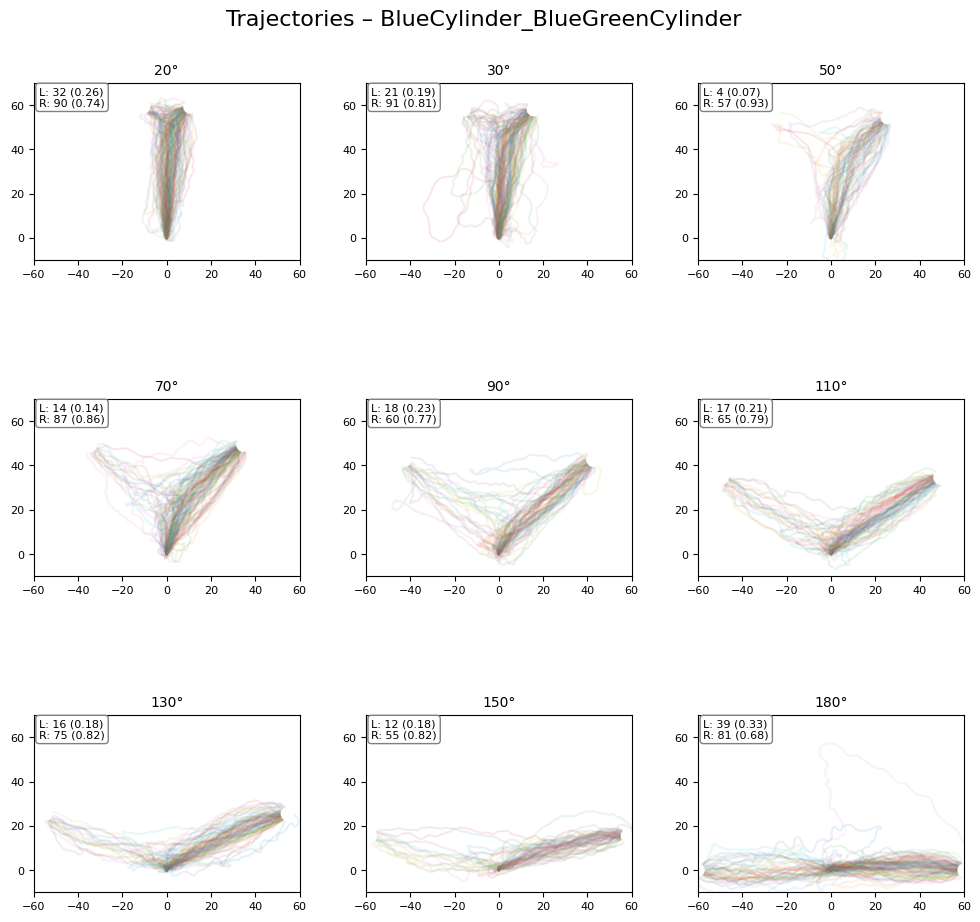

In [4]:
# -----------------------------------------------------------------
#  Trajectories for all  "BlueCylinder_BlueGreenCylinder" configs
#  shown in a grid, sorted by angle
# -----------------------------------------------------------------
import os, math, re
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec

# 1.  Merge once so goal info sits beside positions  (if not done already)
df_joined = pd.merge(
    df_cut,
    results_df[['UniqueTrialID', 'FirstReachedGoal']],
    on='UniqueTrialID',
    how='left'
)

# 2.  Collect the configs of interest & extract angle
angle_pat = re.compile(r'(\d+)(?:deg|°)')   # adjust if encoding differs

records = []
for cfg in df_joined['ConfigFile'].unique():
    if "BlueCylinder_BlueGreenCylinder" not in cfg:
        continue
    m = angle_pat.search(cfg)
    if not m:
        print(f"⚠️  angle missing → skipped: {cfg}")
        continue
    records.append((float(m.group(1)), cfg))

# nothing to show?
if not records:
    raise ValueError("No matching BlueCylinder_BlueGreenCylinder configs found.")

# sort by numeric angle
records.sort(key=lambda t: t[0])            # (angle, cfg)

# 3.  Build grid layout -------------------------------------------------
n_cfg   = len(records)
n_cols  = 3                                 # change to taste
n_rows  = math.ceil(n_cfg / n_cols)

fig = plt.figure(figsize=(n_cols*4, n_rows*3.75))
gs  = gridspec.GridSpec(n_rows, n_cols, wspace=.25, hspace=.35)

# 4.  One sub-plot per config ------------------------------------------
for idx, (angle, cfg) in enumerate(records):
    ax  = fig.add_subplot(gs[idx])
    g   = df_joined[df_joined['ConfigFile'] == cfg]

    # trajectories
    for trial_id, td in g.groupby('UniqueTrialID'):
        ax.plot(td['GameObjectPosX'], td['GameObjectPosZ'], alpha=.1)

    # basic aesthetics
    ax.set_xlim(-40, 40)
    ax.set_ylim(-10, 70)
    ax.set_aspect('equal', adjustable='box')

    ax.set_xticks([-60, -40, -20, 0, 20, 40, 60])      # ← edit to taste
    ax.set_yticks([0, 20, 40, 60])      # ← edit to taste
    ax.tick_params(labelsize=8)               # smaller labels

    ax.set_title(f"{int(angle)}°", fontsize=10)

    # left / right counts & ratios
    res = results_df.loc[results_df['UniqueTrialID'].isin(g['UniqueTrialID'])]
    left  = (res['FirstReachedGoal'] == 'left').sum()
    right = (res['FirstReachedGoal'] == 'right').sum()
    tot   = left + right
    if tot > 0:
        txt = f"L: {left} ({left/tot:.2f})\nR: {right} ({right/tot:.2f})"
    else:
        txt = "no goals"

    ax.text(.02, .98, txt, transform=ax.transAxes, va='top',
            fontsize=8, bbox=dict(boxstyle="round", fc="w", ec=".5"))

# hide any empty cells
for j in range(idx+1, n_rows*n_cols):
    fig.add_subplot(gs[j]).axis('off')

fig.suptitle("Trajectories – BlueCylinder_BlueGreenCylinder",
             y=.92, fontsize=16)
plt.tight_layout()
plt.show()


/Users/apaula/miniforge3/envs/ring_attractor_env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


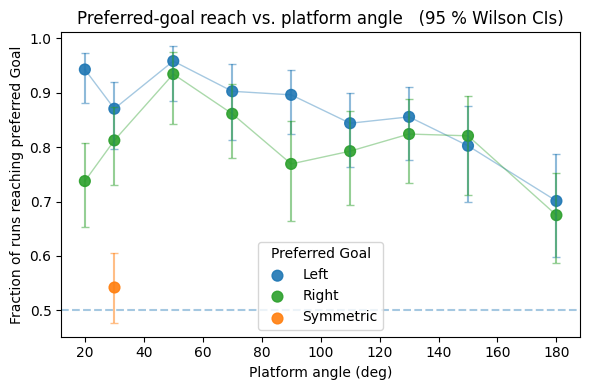

In [5]:
# ------------------------------------------------------------
# Preferred-goal reach vs platform angle      (all two-goal configs)
# ------------------------------------------------------------
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint   # pip install statsmodels

#––– 1.  Merge once so we have the goal info in the movement dataframe –––#
df_joined = pd.merge(
    df_cut,
    results_df[['UniqueTrialID', 'FirstReachedGoal']],
    on='UniqueTrialID',
    how='left'
)

#––– 2.  Per-config goal counts + Wilson CIs ––––––––––––––––––––––––––––#
angle_pat = re.compile(r'(\d+)[°d]')          # adjust if angle is encoded differently
records   = []

for cfg, g in df_joined.groupby('ConfigFile'):
    
    # skip single-goal configs if you have such a list
    if 'center_only_configs' in globals() and cfg in center_only_configs:
        continue
    
    # left / right counts
    res = results_df.loc[results_df['UniqueTrialID'].isin(g['UniqueTrialID'])]
    left  = (res['FirstReachedGoal'] == 'left').sum()
    right = (res['FirstReachedGoal'] == 'right').sum()
    n     = left + right
    if n == 0:
        continue                                # nothing reached a goal
    
    p_left           = left / n
    ci_lo, ci_hi     = proportion_confint(left, n, alpha=.05, method='wilson')
    
    # angle
    m = angle_pat.search(cfg)
    if not m:
        print(f'⚠️  angle not found → skipped: {cfg}')
        continue
    angle = float(m.group(1))
    
    # colour class
    if   "BlueGreenCylinder_BlueCylinder" in cfg:
        colour, label = 'tab:blue',  'BG→B'
    elif "BlueCylinder_BlueGreenCylinder" in cfg:
        colour, label = 'tab:green', 'B→BG'
    else:
        colour, label = 'tab:orange','other'
    
    records.append(dict(
        ConfigFile=cfg,
        angle=angle,
        p_left=p_left, lo_left=ci_lo, hi_left=ci_hi,
        colour=colour, label=label,
        n_trials=n, left_cnt=left, right_cnt=right
    ))

df = pd.DataFrame(records)
df['angle'] = pd.to_numeric(df['angle'])     # <- guarantees float dtype

#––– 3.  Flip B→BG rows so p = fraction reaching their *preferred* goal –––#
flip        = df['label'] == 'B→BG'          # rows to invert
orig_lo     = df.loc[flip, 'lo_left'].values
orig_hi     = df.loc[flip, 'hi_left'].values
orig_p      = df.loc[flip, 'p_left'].values

df.loc[flip, 'p_left']  = 1 - orig_p
df.loc[flip, 'lo_left'] = 1 - orig_hi
df.loc[flip, 'hi_left'] = 1 - orig_lo
df.rename(columns=dict(
    p_left='p_pref', lo_left='lo_pref', hi_left='hi_pref'
), inplace=True)

#––– 4.  Plot ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––#
# --- preferred legend text ----------------------------------
label_map = {
    'BG→B': 'Left',        # BlueGreenCylinder_BlueCylinder
    'B→BG': 'Right',       # BlueCylinder_BlueGreenCylinder
    'other': 'Symmetric'
}

plt.figure(figsize=(6, 4))

for lbl, grp in df.groupby('label'):
    plt.scatter(grp['angle'], grp['p_pref'],
                c=grp['colour'],
                label=label_map[lbl],          # ← mapped text here
                s=60, alpha=.9)

    col = grp['colour'].iloc[0]

    grp = grp.sort_values('angle', key=lambda s: s.astype(float))

    # connecting line
    plt.plot(grp['angle'], grp['p_pref'],
             c=grp['colour'].iloc[0], lw=1, alpha=.4)

    plt.errorbar(grp['angle'], grp['p_pref'],
                 yerr=[grp['p_pref']-grp['lo_pref'],
                       grp['hi_pref']-grp['p_pref']],
                 fmt='none', ecolor=col, alpha=.5, capsize=3)

plt.axhline(.5, ls='--', alpha=.4)
plt.xlabel('Platform angle (deg)')
plt.ylabel('Fraction of runs reaching preferred Goal')
plt.title('Preferred-goal reach vs. platform angle   (95 % Wilson CIs)')

plt.legend(title='Preferred Goal')             # ← new legend title
plt.tight_layout()
plt.show()
